In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

In [6]:

#read in the url and scrape ticker data
data_table = pd.read_csv('Data/NASDAQ100.csv')
# data_table=data_table.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
data_table


,Symbol,Company
0,AMD,Advanced Micro Devices Inc
1,ADBE,Adobe Inc.
2,ALGN,Align Technology Inc
3,AMZN,Amazon.com Inc
4,AMGN,Amgen Inc
...,...,...
98,WBA,Walgreens Boots Alliance Inc
99,WDAY,Workday Inc
100,XEL,Xcel Energy Inc
101,XLNX,Xilinx Inc


In [28]:
############################ run this once And save the results to a csv. Taked approx. 22 mins 
################### Comment after it has executed once. 
# tickers = company_list
tickers = data_table['Symbol'].str.strip()

closing_prices_list = []
for ticker in tickers:
    try:
        prices = pdr.DataReader(ticker,'yahoo','10/21/2020')
        # print(prices)
        prices = prices['Close']
        prices = pd.DataFrame(prices)
        # print(prices)
        prices.columns = [ticker]
        closing_prices_list.append(prices)
        # print(closing_prices_list)
    except:
        pass
    # print(closing_prices_list)
    prices_df = pd.concat(closing_prices_list,axis=1)

prices_df.sort_index(inplace=True)
prices_df
prices_df.to_csv("Data/NASDAQ100prices_df.csv", index=True)

In [30]:
# the data gathered in the above dataframe and saved to csv file is being retrieved here
fromcsv = pd.read_csv('Data/NASDAQ100prices_df.csv')
fromcsv=fromcsv.set_index('Date')
fromcsv

prices_df = fromcsv
prices_df.shape

(254, 103)

In [31]:
prices_df.columns

Index(['AMD', 'ADBE', 'ALGN', 'AMZN', 'AMGN', 'AEP', 'ADI', 'ANSS', 'AAPL',
       'AMAT',
       ...
       'TXN', 'TMUS', 'VRSN', 'VRSK', 'VRTX', 'WBA', 'WDAY', 'XEL', 'XLNX',
       'ZM'],
      dtype='object', length=103)

In [32]:
# prices_df.pct_change()

In [33]:
# prices_df.pct_change() # gets the precentage change across column leaving the first row NAN
# (prices_df.pct_change().sum()/len(prices_df)-1)*len(prices_df)
# this can be replaced by the following

In [34]:
per_change = prices_df.pct_change().mean()*252
per_change = per_change.to_frame()
per_change

,0
AMD,0.487067
ADBE,0.294472
ALGN,0.681129
AMZN,0.078604
AMGN,-0.068388
...,...
WBA,0.325187
WDAY,0.285494
XEL,-0.068217
XLNX,0.517384


In [35]:
# change for time intervel
# ((41.248280-27.372362)/27.372362)*100

In [36]:
# prices_df.pct_change()

In [37]:
per_change = per_change.rename(columns={0:'Returns'})
per_change

,Returns
AMD,0.487067
ADBE,0.294472
ALGN,0.681129
AMZN,0.078604
AMGN,-0.068388
...,...
WBA,0.325187
WDAY,0.285494
XEL,-0.068217
XLNX,0.517384


In [38]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
# returns = prices_df.pct_change().mean() * 252
# returns = pd.DataFrame(returns)
# returns.columns = ['Returns']
per_change['Volatility'] = prices_df.pct_change().std() * sqrt(252)
per_change

,Returns,Volatility
AMD,0.487067,0.386696
ADBE,0.294472,0.264296
ALGN,0.681129,0.510917
AMZN,0.078604,0.255232
AMGN,-0.068388,0.206091
...,...,...
WBA,0.325187,0.334956
WDAY,0.285494,0.352287
XEL,-0.068217,0.193854
XLNX,0.517384,0.401511


# Clusters with Unscaled Data

In [39]:
distortions = []
inertia = []
k = range(1, 11)
# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(per_change)
    distortions.append(sum(np.min(cdist(per_change, km.cluster_centers_,
                                        'euclidean'), axis=1)) / per_change.shape[0])
    inertia.append(km.inertia_)

C:\Users\SMKazmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


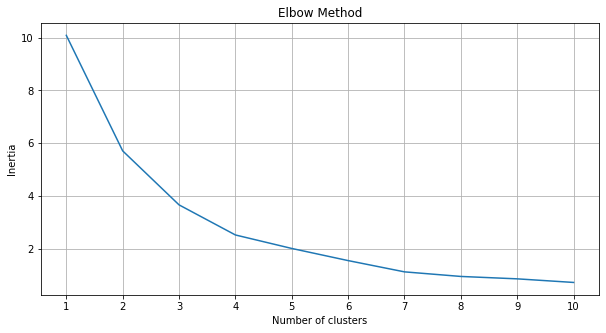

In [40]:
# Create the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
plt.figure(figsize=(10, 5))
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
# plt.plot(df_elbow['k'], distortions, 'bx-')
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.grid(True)
plt.show()

#### Looks like there or 4 or 5 clusters. Let's try scaling the data first

# Clusters with Scaled Data

In [41]:
stock_data_scaled = StandardScaler().fit_transform(per_change)
stock_data_scaled_df = pd.DataFrame(stock_data_scaled)
stock_data_scaled_df.shape
# stock_data_scaled

(103, 2)

In [42]:
distortions = []
inertia = []
k = range(1, 11)
# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(stock_data_scaled)
    distortions.append(sum(np.min(cdist(stock_data_scaled, km.cluster_centers_,
                                        'euclidean'), axis=1)) / stock_data_scaled.shape[0])
    inertia.append(km.inertia_)

C:\Users\SMKazmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


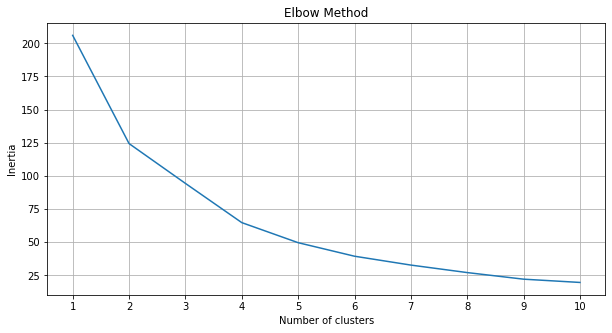

In [43]:
# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
plt.figure(figsize=(10, 5))
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.grid(True)
plt.show()

In [44]:
# Predicting clusters with k=4

# Initialize the k-means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(stock_data_scaled)

# Predict clusters
predictions = model.predict(stock_data_scaled)

In [45]:
# Add the predicted cluster column to the dataframe (name it class)
per_change["Cluster"] = model.labels_
per_change["Cluster"].unique()
centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]


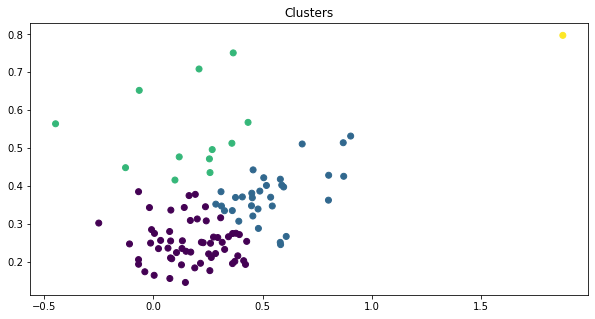

In [46]:
plt.figure(figsize=(10, 5))
plt.scatter(x=per_change['Returns'], y=per_change['Volatility'], c=per_change['Cluster'])

plt.title('Clusters')
plt.show()

In [47]:
per_change = per_change.sort_values(by='Cluster')
per_change = per_change.reset_index()
per_change = per_change.rename(columns={'index':'Stock'})
per_change

,Stock,Returns,Volatility,Cluster
0,MNST,0.078119,0.210580,0
1,MDLZ,0.075034,0.156283,0
2,SBUX,0.284254,0.222034,0
3,DLTR,0.141056,0.343464,0
4,EA,0.132496,0.255675,0
...,...,...,...,...
98,MELI,0.256242,0.471642,2
99,NTES,0.269051,0.496133,2
100,PTON,-0.065098,0.652266,2
101,ZM,-0.448337,0.564173,2


In [48]:
file_path = "Data/Analyzed/Clustered_StocksNASDAQ100.csv"
per_change.to_csv(file_path)

# PCA ??
As there were only 2 features , we do not require any dimenssionality reduction

#### uncomment the following cells if you want to check with PCA (Principal component analysis)

In [155]:
# # Initialize PCA model
# pca = PCA(n_components=0.90)
# stock_data_scaled_df
# stock_data_scaled_df
# # stock_data_scaled
# stock_data_scaled.shape
# stock_data_for_pca = pca.fit_transform(stock_data_scaled)
# stock_data_for_pca.shape
# # stock_data_for_pca
# plt.figure(figsize=(10, 5))
# plt.scatter(x=stock_data_for_pca[:,0], y=stock_data_for_pca[:,1], alpha=0.4)
# plt.title('Cryptocurrency clusters')
# plt.show()

In [156]:
# distortions = []
# inertia = []
# k = range(1, 11)
# # Calculate the inertia for the range of k values
# for i in k:
#     km = KMeans(n_clusters=i, random_state=0)
#     km.fit(stock_data_for_pca)
#     distortions.append(sum(np.min(cdist(stock_data_for_pca, km.cluster_centers_,
#                                         'euclidean'), axis=1)) / stock_data_for_pca.shape[0])
#     inertia.append(km.inertia_)
# # # Add the predicted cluster column to the dataframe (name it class)
# # per_change["Cluster"] = model.labels_
# # per_change["Cluster"].unique()
# # centroids = model.cluster_centers_
# # centroids_x = centroids[:,0]
# # centroids_y = centroids[:,1]
# # Predicting clusters with k=4


In [157]:

# # Initialize the k-means model
# model = KMeans(n_clusters=4, random_state=0)

# # Fit the model
# model.fit(stock_data_for_pca)

# # Predict clusters
# predictions = model.predict(stock_data_for_pca)
# plt.figure(figsize=(8, 4))
# plt.scatter(x=stock_data_for_pca[:,0], y=stock_data_for_pca[:,1], c=model.labels_)
# plt.title('Stock Clusters')
# plt.show()